In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model


%matplotlib inline

In [2]:
df_train = pd.read_csv("/data/MNIST/mnist_train.csv", header= None)
df_train.shape

(60000, 785)

In [3]:
df_test = pd.read_csv("/data/MNIST/mnist_test.csv", header= None)
df_test.shape

(10000, 785)

In [4]:
28*28 

784

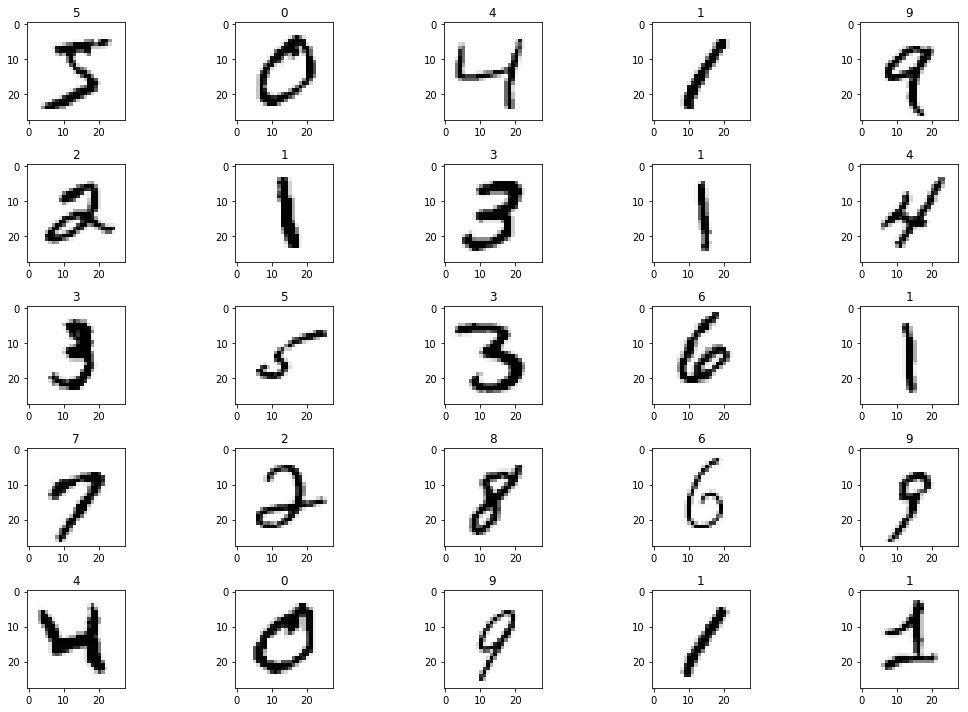

In [5]:
fig, _ = plt.subplots(5, 5, figsize = (15, 10))
for i, ax in enumerate(fig.axes):
    ax.imshow(df_train.iloc[i, 1:].values.reshape(28, -1), cmap="Greys")
    ax.set_title(df_train.iloc[i, 0])

plt.tight_layout()

In [6]:
X_train = df_train.iloc[:, 1:].values
X_test = df_test.iloc[:, 1:].values
y_train = df_train.iloc[:, 0]
y_test = df_test.iloc[:, 0]


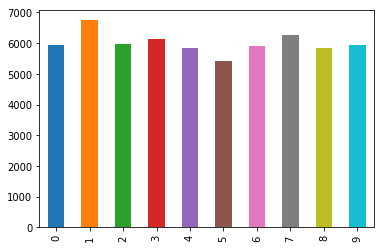

In [7]:
pd.Series(y_train).value_counts().sort_index().plot.bar()

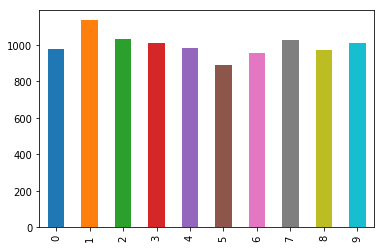

In [8]:
pd.Series(y_test).value_counts().sort_index().plot.bar()

In [9]:
from sklearn import preprocessing
import numpy as np

In [10]:
scaler = preprocessing.StandardScaler()
X_train_std = scaler.fit_transform(X_train.astype(np.float64))
X_test_std = scaler.transform(X_test.astype(np.float64))

In [47]:
%%time
est = linear_model.LogisticRegression(C = 1.0, random_state = 1)
est.fit(X_train_std, y_train)
print("accuracy", est.score(X_test_std, y_test), "iterations:", est.n_iter_)

accuracy 0.9171 iterations: [14]
CPU times: user 11min 46s, sys: 1.73 s, total: 11min 48s
Wall time: 11min 49s


In [44]:
import scipy

In [11]:
inits = np.random.randn(10, 784) 
inits = inits / np.std(inits, axis=1).reshape(10, -1)

In [17]:
%%time
est = linear_model.SGDClassifier(n_jobs=4, tol=1e-5, eta0 = 0.15, random_state=1,  
                                 learning_rate = "invscaling", 
                                 alpha = 0.01, max_iter= 100)
est.fit(X_train_std, y_train, inits)
print("accuracy", est.score(X_test_std, y_test), "iterations:", est.n_iter_)

accuracy 0.9192 iterations: 17
CPU times: user 11.4 s, sys: 709 ms, total: 12.1 s
Wall time: 4.43 s


In [15]:
est.coef_.shape

(10, 784)

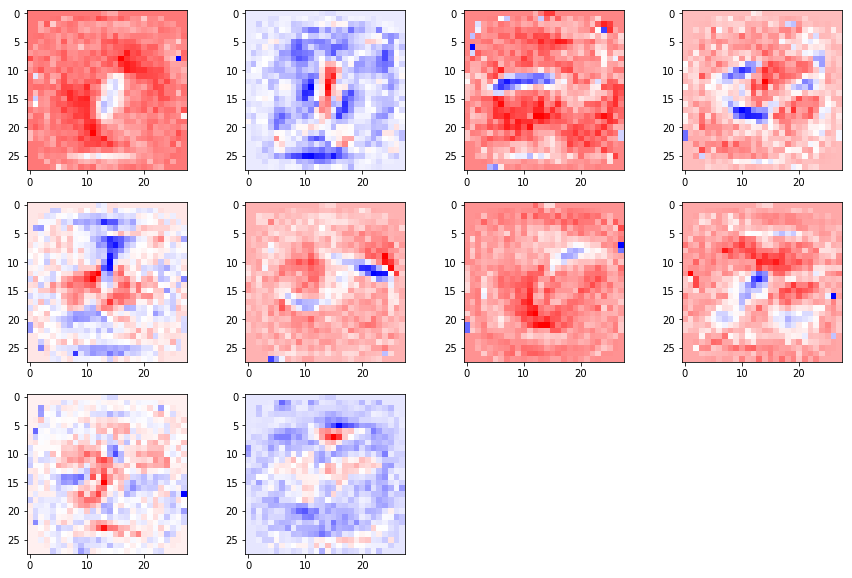

In [68]:
fig, _ = plt.subplots(3, 4, figsize = (15, 10))
for i, ax in enumerate(fig.axes):
    if i < est.coef_.shape[0]:
        ax.imshow(est.coef_[i, :].reshape(28, 28), cmap = "bwr", interpolation="nearest")
    else:
        ax.remove()

In [18]:
import tensorflow as tf

/Users/abulbasar/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Batch gradient descent

In [41]:
tf.reset_default_graph()
n_x, n_y = X_train_std.shape[1], 10 # number of features of df is 4, and output is single value 
max_iter = 250
alpha = 100


X = tf.placeholder(dtype=tf.float32, shape=[None, n_x], name = "X")
y = tf.placeholder(dtype=tf.int32, shape=[None], name = "y")

y_oh = tf.one_hot(y, name = "y_oh", depth = n_y)

print("X:", X)
print("y:", y)

W = tf.Variable(tf.truncated_normal([n_x, n_y], stddev=0.1, seed = 1, dtype=tf.float32), name = "W")
b = tf.Variable(tf.zeros(shape=[n_y]), dtype=tf.float32, name="b")

Z = tf.matmul(X, W) + b
print("Z: ", Z)

y_pred = tf.cast(tf.argmax(Z, axis=1), tf.int32)
print("y_pred: ", y_pred)

matched = tf.equal(y_pred, y)
print("matched:", matched)

accuracy = tf.reduce_mean(tf.cast(matched, tf.float32))
print("accuracy: ", accuracy)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits = Z))

optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(cost)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    scores = {}
    for i in range(max_iter):
        cost_,_ = sess.run([cost, optimizer], feed_dict={X: X_train_std, y: y_train})
        scores[i] = cost_
        if i % (max_iter // 10) == 0:
            print(i, cost_)
   
    accuracy_ = sess.run(accuracy, feed_dict={X: X_test_std, y: y_test})

    print("Test accuracy: ", accuracy_)
    pd.Series(scores).plot()

X: Tensor("X:0", shape=(?, 784), dtype=float32)
y: Tensor("y:0", shape=(?,), dtype=int32)
Z:  Tensor("add:0", shape=(?, 10), dtype=float32)
y_pred:  Tensor("Cast:0", shape=(?,), dtype=int32)
matched: Tensor("Equal:0", shape=(?,), dtype=bool)
accuracy:  Tensor("Mean:0", shape=(), dtype=float32)
0 3.52437
25 0.914085


KeyboardInterrupt: 

# Mini batch gradient descent

In [42]:
import requests
url = "https://raw.githubusercontent.com/abulbasar/machine-learning/master/Utils.py"
exec(requests.get(url).text)

X: Tensor("X:0", shape=(?, 784), dtype=float32)
y: Tensor("y:0", shape=(?,), dtype=int32)
Z:  Tensor("add:0", shape=(?, 10), dtype=float32)
y_pred:  Tensor("Cast:0", shape=(?,), dtype=int32)
matched: Tensor("Equal:0", shape=(?,), dtype=bool)
accuracy:  Tensor("Mean:0", shape=(), dtype=float32)
0 3.63887
100 0.484621
200 1.73197
300 0.762925
400 0.244644
500 0.529764
600 0.286891
700 0.160542
800 0.439102
900 0.770548
Test accuracy:  0.9174


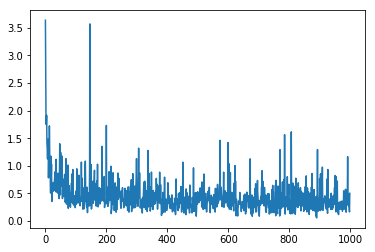

In [48]:
tf.reset_default_graph()
n_x, n_y = X_train_std.shape[1], 10 # number of features of df is 4, and output is single value 
max_iter = 1000
alpha = 100


X = tf.placeholder(dtype=tf.float32, shape=[None, n_x], name = "X")
y = tf.placeholder(dtype=tf.int32, shape=[None], name = "y")

y_oh = tf.one_hot(y, name = "y_oh", depth = n_y)

print("X:", X)
print("y:", y)

W = tf.Variable(tf.truncated_normal([n_x, n_y], stddev=0.1, seed = 1, dtype=tf.float32), name = "W")
b = tf.Variable(tf.zeros(shape=[n_y]), dtype=tf.float32, name="b")

Z = tf.matmul(X, W) + b
print("Z: ", Z)

y_pred = tf.cast(tf.argmax(Z, axis=1), tf.int32)
print("y_pred: ", y_pred)

matched = tf.equal(y_pred, y)
print("matched:", matched)

accuracy = tf.reduce_mean(tf.cast(matched, tf.float32))
print("accuracy: ", accuracy)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits = Z))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    scores = {}
    
    batchable = Batchable(X_train_std, y_train, batch_size=64, seed=1)
    
    for i in range(max_iter):
        X_batch, y_batch = batchable.next()
        cost_,_ = sess.run([cost, optimizer], feed_dict={X: X_batch, y: y_batch})
        scores[i] = cost_
        if i % (max_iter // 10) == 0:
            print(i, cost_)
   
    accuracy_ = sess.run(accuracy, feed_dict={X: X_test_std, y: y_test})

    print("Test accuracy: ", accuracy_)
    pd.Series(scores).plot()
    
    

# No hidden layer 

X: Tensor("X:0", shape=(?, 784), dtype=float32)
y: Tensor("y:0", shape=(?,), dtype=int32)
Z:  Tensor("add:0", shape=(?, 10), dtype=float32)
y_pred:  Tensor("Cast:0", shape=(?,), dtype=int32)
matched: Tensor("Equal:0", shape=(?,), dtype=bool)
accuracy:  Tensor("Mean:0", shape=(), dtype=float32)
0 3.63887
100 0.484621
200 1.73197
300 0.762925
400 0.244644
500 0.529764
600 0.286891
700 0.160542
800 0.439102
900 0.770548
Test accuracy:  0.9174


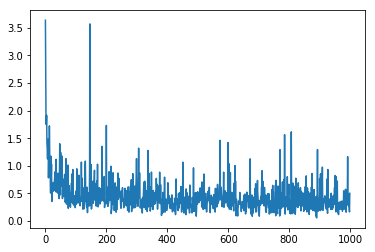

In [54]:
tf.reset_default_graph()
n_x, n_y = X_train_std.shape[1], 10 # number of features of df is 4, and output is single value 
max_iter = 1000
alpha = 100


X = tf.placeholder(dtype=tf.float32, shape=[None, n_x], name = "X")
y = tf.placeholder(dtype=tf.int32, shape=[None], name = "y")

y_oh = tf.one_hot(y, name = "y_oh", depth = n_y)

print("X:", X)
print("y:", y)

W1 = tf.Variable(tf.truncated_normal([n_x, n_y], stddev=0.1, seed = 1, dtype=tf.float32), name = "W")
b1 = tf.Variable(tf.zeros(shape=[n_y]), dtype=tf.float32, name="b")

Z1 = tf.matmul(X, W1) + b1
print("Z: ", Z1)

y_pred = tf.cast(tf.argmax(Z1, axis=1), tf.int32)
print("y_pred: ", y_pred)

matched = tf.equal(y_pred, y)
print("matched:", matched)

accuracy = tf.reduce_mean(tf.cast(matched, tf.float32))
print("accuracy: ", accuracy)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits = Z1))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    scores = {}
    
    batchable = Batchable(X_train_std, y_train, batch_size=64, seed=1)
    
    for i in range(max_iter):
        X_batch, y_batch = batchable.next()
        cost_,_ = sess.run([cost, optimizer], feed_dict={X: X_batch, y: y_batch})
        scores[i] = cost_
        if i % (max_iter // 10) == 0:
            print(i, cost_)
   
    accuracy_ = sess.run(accuracy, feed_dict={X: X_test_std, y: y_test})

    print("Test accuracy: ", accuracy_)
    pd.Series(scores).plot()
    
    

X: Tensor("X:0", shape=(?, 784), dtype=float32)
y: Tensor("y:0", shape=(?,), dtype=int32)
Z:  Tensor("add:0", shape=(?, 200), dtype=float32)
A1: Tensor("Tanh:0", shape=(?, 200), dtype=float32)
Z:  Tensor("add:0", shape=(?, 200), dtype=float32)
y_pred:  Tensor("Cast:0", shape=(?,), dtype=int32)
matched: Tensor("Equal:0", shape=(?,), dtype=bool)
accuracy:  Tensor("Mean:0", shape=(), dtype=float32)
0 3.60645
100 1.60136
200 1.34029
300 1.39705
400 1.14989
500 1.29865
600 1.16924
700 1.05121
800 1.23276
900 1.32962
Test accuracy:  0.9204


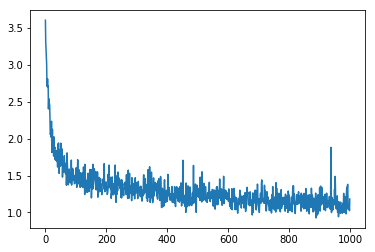

In [64]:
tf.reset_default_graph()
n_x, n_y = X_train_std.shape[1], 10 # number of features of df is 4, and output is single value 
max_iter = 1000
alpha = 100
n_h = 200

X = tf.placeholder(dtype=tf.float32, shape=[None, n_x], name = "X")
y = tf.placeholder(dtype=tf.int32, shape=[None], name = "y")

y_oh = tf.one_hot(y, name = "y_oh", depth = n_y)

print("X:", X)
print("y:", y)

W1 = tf.Variable(tf.truncated_normal([n_x, n_h], stddev=0.1, seed = 1, dtype=tf.float32), name = "W1")
b1 = tf.Variable(tf.zeros(shape=[n_h]), dtype=tf.float32, name="b1")

Z1 = tf.matmul(X, W1) + b1
print("Z: ", Z1)

A1 = tf.nn.tanh(Z1)
print("A1:", A1)

W2 = tf.Variable(tf.truncated_normal([n_h, n_y], stddev=0.1, seed = 1, dtype=tf.float32), name = "W2")
b2 = tf.Variable(tf.zeros(shape=[n_y]), dtype=tf.float32, name="b2")

Z2 = tf.matmul(A1, W2) + b2
print("Z: ", Z1)


y_pred = tf.cast(tf.argmax(Z2, axis=1), tf.int32)
print("y_pred: ", y_pred)

matched = tf.equal(y_pred, y)
print("matched:", matched)

accuracy = tf.reduce_mean(tf.cast(matched, tf.float32))
print("accuracy: ", accuracy)

reg_penalty = (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)) / tf.cast(tf.shape(X)[0], tf.float32)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits = Z2)) + 0.1 * reg_penalty

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(cost)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    scores = {}
    
    batchable = Batchable(X_train_std, y_train, batch_size=64, seed=1)
    
    for i in range(max_iter):
        X_batch, y_batch = batchable.next()
        cost_,_ = sess.run([cost, optimizer], feed_dict={X: X_batch, y: y_batch})
        scores[i] = cost_
        if i % (max_iter // 10) == 0:
            print(i, cost_)
   
    accuracy_, y_test_pred = sess.run([accuracy, y_pred], feed_dict={X: X_test_std, y: y_test})

    print("Test accuracy: ", accuracy_)
    pd.Series(scores).plot()
    
    